In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys 
import os

# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset
from rulevetting.projects.csi_pecarn.tree_functions import *
from rulevetting.projects.csi_pecarn.baseline import Baseline
from rulevetting.projects.csi_pecarn.model_best import SpecialTree

from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

/accounts/grad/wtorous/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


/accounts/grad/wtorous/rule-vetting


In [2]:
def classify_experiment_results(experiment_df, use_matching=False, name_str=''):
    # compute confusion matrix entries
    TN = experiment_df[ (experiment_df['pred'] == 0) & (experiment_df['csi_injury'] == 0)].shape[0]
    TP = experiment_df[ (experiment_df['pred'] == 1) & (experiment_df['csi_injury'] == 1)].shape[0]
    FN = experiment_df[ (experiment_df['pred'] == 0) & (experiment_df['csi_injury'] == 1)].shape[0]
    FP = experiment_df[ (experiment_df['pred'] == 1) & (experiment_df['csi_injury'] == 0)].shape[0]
    sensitivity = TP/(FN+TP)
    specificity = TN/(FP+TN)
    confusion_data = None
    
    if use_matching:
        # fist get groups (by case_id) that have both a case and a control
        ungrouped_data = experiment_df.reset_index()
        max_grouped_data = ungrouped_data.groupby(by=['case_id', 'control_type']).max()
        max_ungrouped_data = max_grouped_data.reset_index()
        
        boolean_groups = max_grouped_data.reset_index().groupby(by=['case_id']).size() > 1
        complete_groups = boolean_groups[boolean_groups].index.values
        filtered_df = max_ungrouped_data[max_ungrouped_data.case_id.isin(complete_groups)]
        
        correct_cases = filtered_df[((filtered_df['control_type'])=='case') & ((filtered_df['pred'])==1)]['case_id']
        incorrect_cases = filtered_df[((filtered_df['control_type'])=='case') & ((filtered_df['pred'])==0)]['case_id']
        correct_controls = filtered_df[((filtered_df['control_type'])!='case') & ((filtered_df['pred'])==0)]['case_id']
        incorrect_controls = filtered_df[((filtered_df['control_type'])!='case') & ((filtered_df['pred'])==1)]['case_id']
        
        num_cases = len(correct_cases)+len(incorrect_cases)
        correct_frac = len(set(correct_cases).intersection(set(correct_controls))) / num_cases
        all_pos_frac = len(set(correct_cases).intersection(set(incorrect_controls))) / num_cases
        all_neg_frac = len(set(incorrect_cases).intersection(set(correct_controls))) / num_cases
        flipped_frac = 1 - correct_frac - all_pos_frac - all_neg_frac
        
        confusion_data = np.array([[correct_frac,all_pos_frac],[all_neg_frac,flipped_frac]])
        confusion_df = pd.DataFrame(confusion_data,columns=['Predicted No Injury', 'Predicted Injury'],index=['Predicted Injury','Predicted No Injury'])
        sns.heatmap(confusion_df,cbar=False,annot=True)
        plt.xlabel('Controls', fontsize=10)
        plt.ylabel('Case', fontsize=10)
        plt.title('{0} Confusion Matrix'.format(name_str))
        plt.show()
        
    return (sensitivity, specificity, confusion_data)

In [3]:
def run_experiment(contol_types = ['ran'], description=''):
    
    use_matching=True
    if contol_types == ['ran']: use_matching=False
    # get data 
    
    df_ran = Dataset().get_data(control_types=contol_types)

    df0 = df_ran[0]
    df1 = df_ran[1]
    df2 = df_ran[2]
    data_train = pd.concat([df0,df1])
    data_test = df2
    print(data_train.shape,data_test.shape)
    results_dict = {}

    #####
    # SpecialTree on training+tuning

    pred_train = SpecialTree(data_train).predict()
    evaluate = pd.DataFrame(data = {'csi_injury': data_train['csi_injury'], 
                                    'pred': pred_train})
    st_results = classify_experiment_results(evaluate,use_matching,name_str=description + "Special Tree Training")
    results_dict['ST_train'] = (st_results[0],st_results[1])
    
    #####
    # Baseline on training+tuning

    pred_train = Baseline(data_train).predict()
    evaluate = pd.DataFrame(data = {'csi_injury': data_train['csi_injury'], 
                                    'pred': pred_train})
    bt_results = classify_experiment_results(evaluate,use_matching,name_str=description + "Baseline Training")
    results_dict['B_train'] = (bt_results[0],bt_results[1])
    #####
    # SpecialTree on on unseen testing

    pred_test = SpecialTree(data_test).predict()
    evaluate = pd.DataFrame(data = {'csi_injury': data_test['csi_injury'], 
                                    'pred': pred_test})
    stt_results = classify_experiment_results(evaluate,use_matching,name_str=description + "Special Tree Testing")
    results_dict['ST_test'] = (stt_results[0],stt_results[1])
    #####
    # Baseline on unseen testing

    pred_test = Baseline(data_test).predict()
    evaluate = pd.DataFrame(data = {'csi_injury': data_test['csi_injury'], 
                                    'pred': pred_test})
    btt_results = classify_experiment_results(evaluate,use_matching,name_str=description + "Baseline Testing")
    results_dict['B_test'] = (btt_results[0],btt_results[1])
    
    return results_dict

In [4]:
results_df = pd.DataFrame(columns=["ST_train_sens","ST_train_spec","B_train_sens","B_train_spec"\
                                   ,"ST_test_sens","ST_test_spec","B_test_sens","B_test_spec"])

/accounts/grad/wtorous/rule-vetting/rulevetting/projects/csi_pecarn/helper.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[base_av_improved][df[base_av+'_binary'].copy()==1] = 0 # condition remains indicated at study site


split_data kwargs {'control_types': ['ems']}
['ems']
(872, 95) (235, 95)


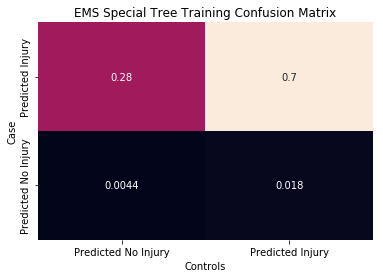

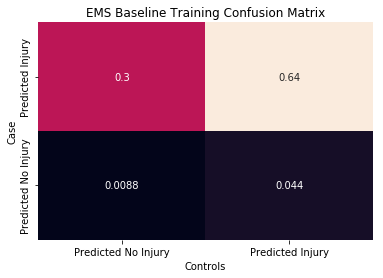

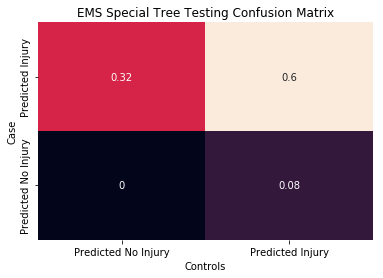

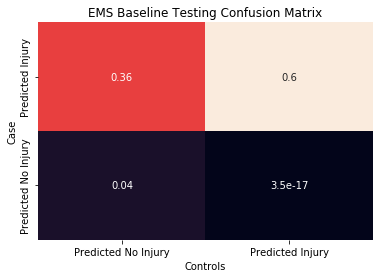

In [5]:
ems_controls_result = run_experiment(['ems'],description='EMS ')

for key, value in ems_controls_result.items():
    results_df.loc['ems',key+'_sens'] = value[0]
    results_df.loc['ems',key+'_spec'] = value[1]

In [6]:
random_controls_result = run_experiment()

for key, value in random_controls_result.items():
    results_df.loc['ran',key+'_sens'] = value[0]
    results_df.loc['ran',key+'_spec'] = value[1]

(1100, 95) (290, 95)


split_data kwargs {'control_types': ['moi']}
['moi']
(1067, 95) (282, 95)


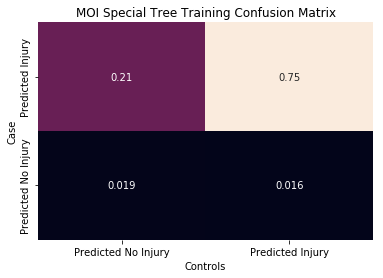

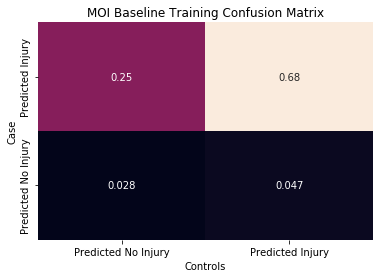

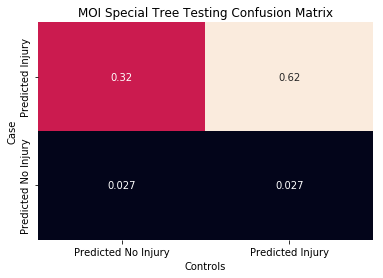

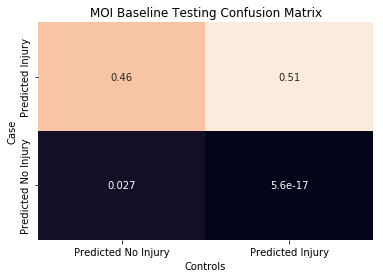

In [7]:
moi_controls_result = run_experiment(['moi'],description='MOI ')

for key, value in moi_controls_result.items():
    results_df.loc['moi',key+'_sens'] = value[0]
    results_df.loc['moi',key+'_spec'] = value[1]

split_data kwargs {'control_types': ['ems', 'moi']}
['ems', 'moi']
(1560, 95) (414, 95)


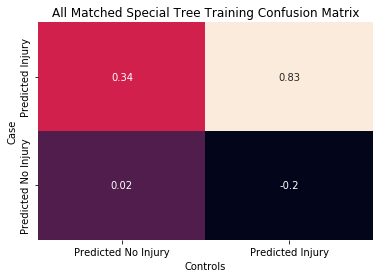

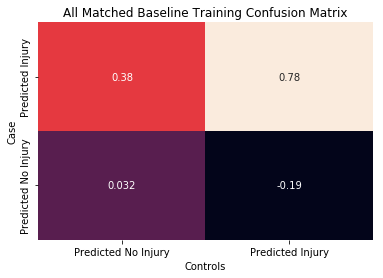

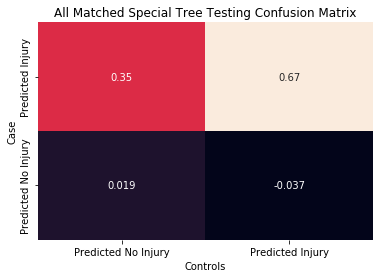

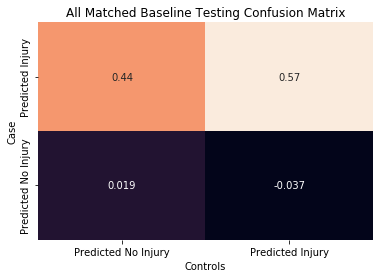

In [8]:
all_controls_result = run_experiment(['ems','moi'],description='All Matched ')

for key, value in all_controls_result.items():
    results_df.loc['all',key+'_sens'] = value[0]
    results_df.loc['all',key+'_spec'] = value[1]

In [9]:
specificity_df = results_df[[col for col in results_df.columns.astype(str) if 'spec' in col]]
#specificity_df['Control Group'] = specificity_df.index

In [10]:
specificity_df.index = ['EMS','Random','MOI','Combined']
specificity_df.columns = ['Special Tree Training','Baseline Training','Special Tree Testing','Baseline Testing']

Text(0, 0.5, 'Specificity')

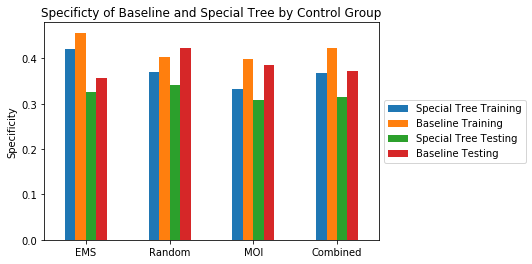

In [11]:
specificity_df.plot.bar(rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Specificty of Baseline and Special Tree by Control Group")
plt.ylabel("Specificity")